# K Nearest Neighbours (KNN)

In [2]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from scipy import stats
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

## Distance computation

In [3]:
def euclidean_distance(x1, x2):
    '''Computes Euclidean distance between two points x1 and x2
    
    Args:
        x1: Point 1
        x2: Point 2

    returns:
        dist: Euclidean distance
    '''
    dist = np.sum((x1 -x2)**2, axis = 1)
    return dist

def manhattan_distance(x1, x2):
    '''Computes Manhattan distance between two points x1 and x2
    
    Args:
        x1: Point 1
        x2: Point 2

    returns:
        dist: Manhattan distance
    '''
    dist = np.sum(np.abs(x1 -x2), axis = 1)
    return dist

## KNN Implementation

In [13]:
class KNN:
    def __init__(self, k, distance_metric = euclidean_distance, task_type = "Classification"):

        self._k = k
        self._distance_metric = distance_metric
        self._task_type = task_type

    def fit(self, X, y):
        ''' Stores training data for KNN
        Args:
            X: Feature matrix
            y: labels
        
        Returns:
             ------------
        '''
        self._X = X
        self._y = y

    def predict(self, new_example):
        '''Predict the class labels for a new example supplied
        Args:
            new_example: New examples

        Returns:
            label: Predicted labels for new_example
            knn_indices: Indices of K nearest neighbours
        '''

        distance_vector  = self._distance_metric(self._X, new_example)

        knn_indices = np.argpartition(distance_vector, self._k)[:self._k]

        knn = self._y[knn_indices]

        if self._task_type == 'Classification':
            label = stats.mode(knn)[0]

        else:
            label = knn.mean()

        return label, knn_indices

    def eval(self, X_test, y_test):
        '''Evaluates KNN
        Args:
            X_test: feature matrix
            y_test: labels

        Returns:
            Misclassification error
        '''
        if self._task_type == 'Classification':
            y_pred = np.zeros(y_test.shape)
            for i in range(y_test.shape[0]):
                y_pred[i], _ = self.predict(X_test[i,:]) 
            error = np.mean(y_test == y_pred, axis = 0)
        else:
            y_pred = np.zeros(y_test.shape)
            for i in range(y_test.shape[0]):
                y_pred[i], _ = self.predict(X_test[i,:]) 
            error_vector = y_pred - y_test
            error = np.sqrt((error_vector.T @ error_vector)/ error_vector.ravel().shape[0])

        return error

## Classification

### Example 1: Simple decision boundary

Let's generate 100 points, each represented with two features and a class label. The point are generated such that they are clustered into two groups with mean [0, 0] and [5, 5] with standard deviation 1.

In [14]:
X, y = make_blobs(n_samples = 100,
                    n_features = 2,
                    centers = [[0, 0], [5, 5]],
                    cluster_std = 1,
                    random_state = 12)


In [15]:
print("Shape of feature matrix: ", X.shape)
print("Shape of label vector: ", y.shape)

Shape of feature matrix:  (100, 2)
Shape of label vector:  (100,)


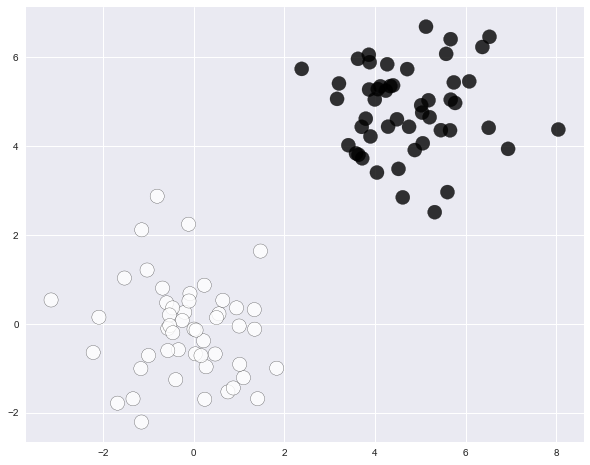

In [16]:
#Visualisation
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], marker='o', c = y,
            s=200, edgecolors='k', alpha=0.8)
plt.show()

In [17]:
new_example = np.array([2.2, 2.2])

model = KNN(3, distance_metric=euclidean_distance)

model.fit(X, y)

prediction, nearest_neighbour_indices = model.predict(new_example.reshape(1,2))

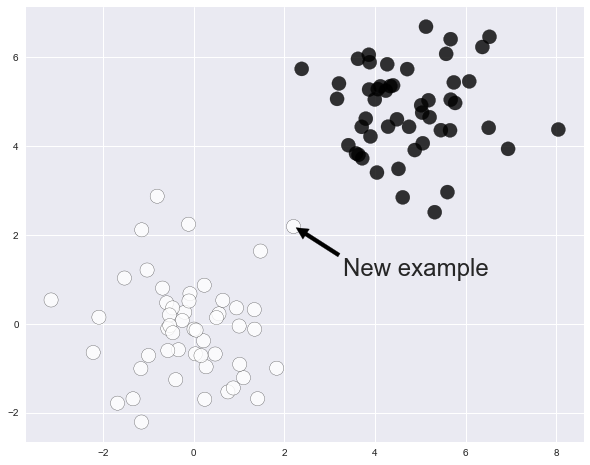

In [19]:
#Visualisation
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], marker='o', c = y,
            s=200, edgecolors='k', alpha=0.8)
plt.scatter(new_example[0], new_example[1], marker='o', c = 'white',
            s=200, edgecolors='k', alpha=0.8)
plt.annotate('New example', xy = new_example, xytext=(50, -50),
            textcoords='offset points', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=24)
plt.show()

Nearest neighbours

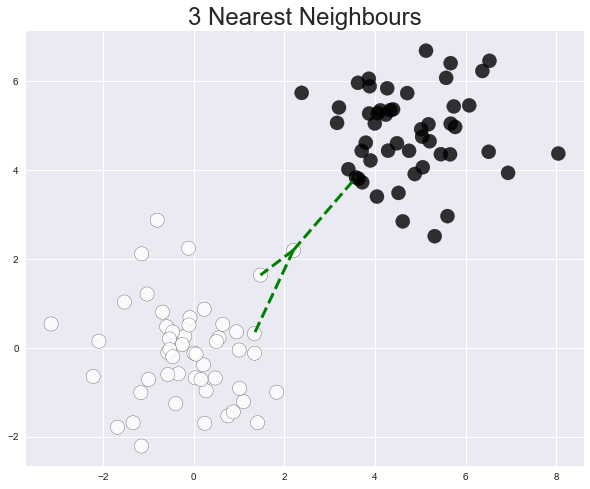

In [21]:
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], marker='o', c = y,
            s=200, edgecolors='k', alpha=0.8)
plt.scatter(new_example[0], new_example[1], marker='o', c = 'white',
            s=200, edgecolors='k', alpha=0.8)

for xi in X[nearest_neighbour_indices]:
    plt.plot([new_example[0], xi[0]], [new_example[1], xi[1]], 'g--', linewidth=3)

plt.title("3 Nearest Neighbours", fontsize=24)
plt.show()

### Simple decision boundary

In [22]:
def draw_decsion_boundary(model, axis_chart, num_points=201, opacity=0.05):

    tx = np.linspace(np.min(model._X[:, 0], axis = 0) - 2,
                        np.max(model._X[:, 0], axis=0) + 2, num_points)
    ty = np.linspace(np.min(model._X[:, 1], axis = 0) - 2,
                        np.max(model._X[:, 1], axis=0) + 2, num_points)

    xx, yy = np.meshgrid(tx, ty)
    grid_prediction = np.zeros(xx.shape)

    for i in range(num_points):
        for j in range(num_points):
            grid_prediction[i][j], _ = model.predict([xx[i][j], yy[i][j]])

    axis_chart.scatter(xx.ravel(), yy.ravel(),
                        c = grid_prediction.ravel(), alpha = opacity)

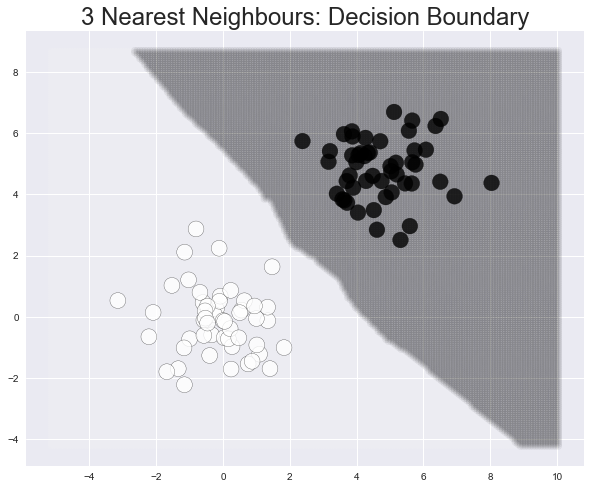

In [23]:
plt.figure(figsize=(10,8))
current_axis = plt.gca()
plt.grid(True)

draw_decsion_boundary(model, current_axis)

plt.scatter(X[:, 0 ], X[:, 1], marker='o', c = y,
            s = 250, edgecolors='k', alpha=0.8)

plt.title("3 Nearest Neighbours: Decision Boundary", fontsize=24)
plt.show()

### Complex decison boundary

In [24]:
def make_two_spirals(num_points=1000, rotations = 2, noise = 0.5):
    '''Make  a synthetic dataset of two classes in the form of spirals
    Args: 
        num_points: No. of points to be gereated per spiral
        rotations: How many times a spiral shoul rotate
        noise: noise factor

    Returns:
        Coordinates and class vectors of the two spirals
    '''

    n = np.sqrt(np.random.rand(num_points, 1)) * rotations * (2 * np.pi)
    rx = -np.cos(n) * n + np.random.rand(num_points, 1) * noise
    ry = np.sin(n) * n + np.random.rand(num_points, 1) * noise

    return (np.concatenate((np.hstack((rx, ry)),
                            np.hstack((-rx, -ry))),
                                        axis = 0),
            np.concatenate((np.zeros(num_points),
                            np.ones(num_points)),
                            axis = 0))

X_spiral, y_spiral = make_two_spirals()

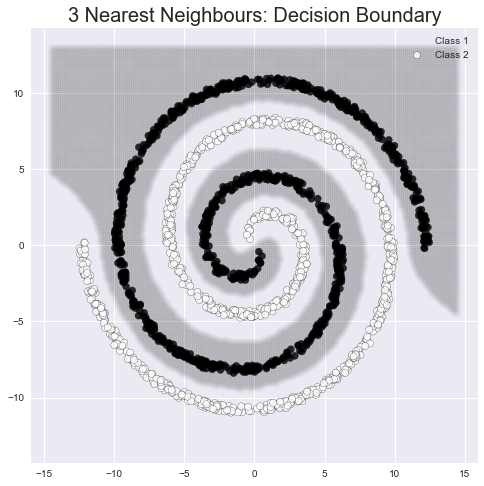

In [26]:
plt.figure(figsize=(8,8))

model = KNN(3)
model.fit(X_spiral, y_spiral)

draw_decsion_boundary(model, plt.gca(), opacity=0.02)

plt.scatter(X_spiral[:, 0 ], X_spiral[:, 1], marker='o', c = y_spiral,
            s = 50, edgecolors='k', alpha=0.8)

plt.title("3 Nearest Neighbours: Decision Boundary", fontsize=20)
plt.legend(['Class 1', 'Class 2'])
plt.show()

## Regression

In [27]:
np.random.seed(42)

w1 = 3
w0 = 4
n = 100

X = 2 * np.random.rand(n,)
y = w0 + w1 * X + np.random.randn(n,)

In [28]:
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

In [29]:
print("Shape of the training data feature matrix: ", X.shape)
print("Shape of label vector: ", y.shape)

Shape of the training data feature matrix:  (100, 1)
Shape of label vector:  (100, 1)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

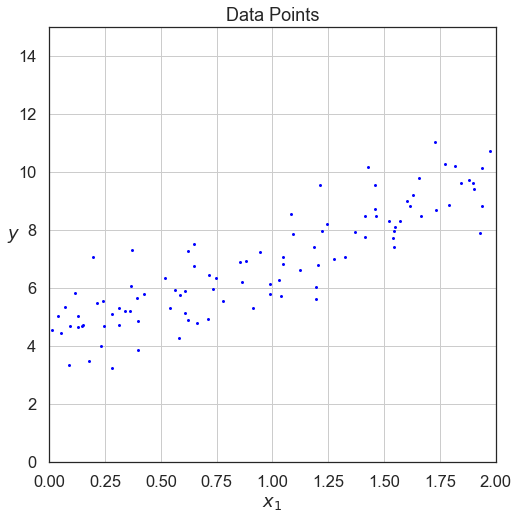

In [31]:
sns.set_style("white")
f = plt.figure(figsize=(8,8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.plot(X, y, "b.")
plt.title("Data Points")
plt.grid(True)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.axis([0, 2, 0, 15])
plt.show()

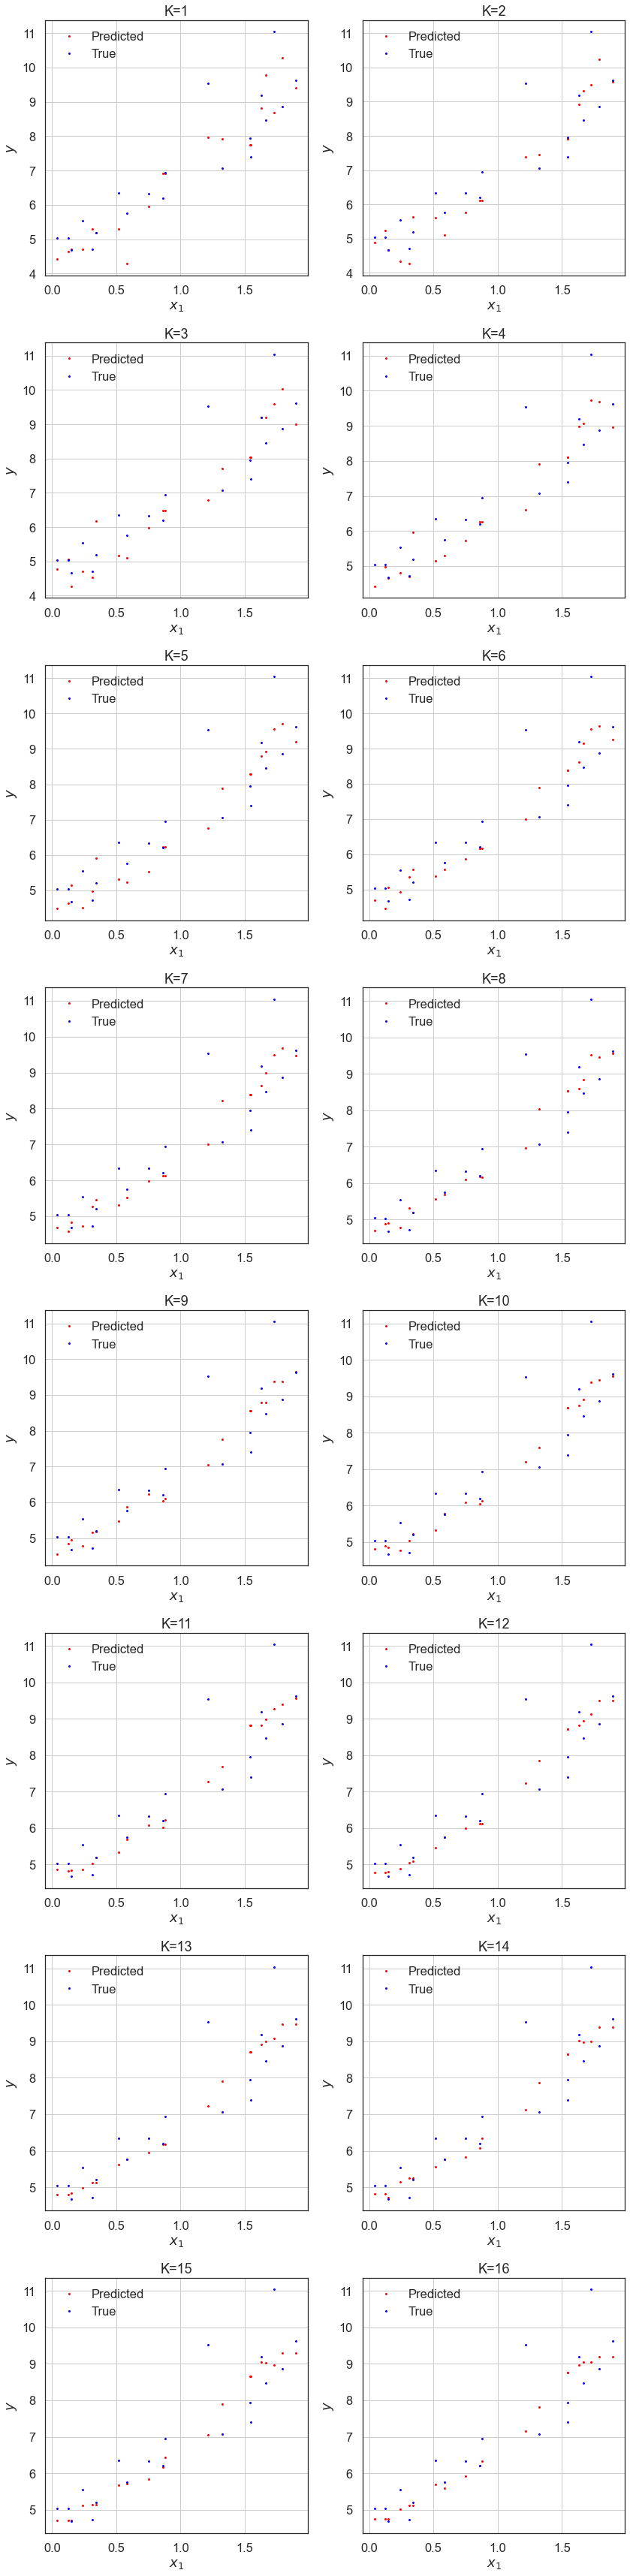

In [33]:
figure, axis = plt.subplots(8, 2, figsize=(12, 48))
axis = axis.ravel()

error_list = []
for i in range(16):
    model = KNN(i+1, task_type='Regression')

    model.fit(X_train, y_train)

    y_test_predicted = np.zeros_like(y_test)

    for j in range(X_test.shape[0]):
        y_test_predicted[j], _ = model.predict(X_test[j, :])

    error_list.append(np.sum(np.power(y_test - y_test_predicted, 2)))

    #plot predictions
    axis[i].plot(X_test, y_test_predicted, "r.")

    #plot ground truth
    axis[i].plot(X_test, y_test, "b.") 
    axis[i].legend(["Predicted", "True"])

    #set title
    axis[i].set_title(f"K={i+1}")

    axis[i].grid("True")
    axis[i].set(xlabel="$x_1$", ylabel = "$y$")

figure.tight_layout()
plt.show()

Text(0, 0.5, 'Error')

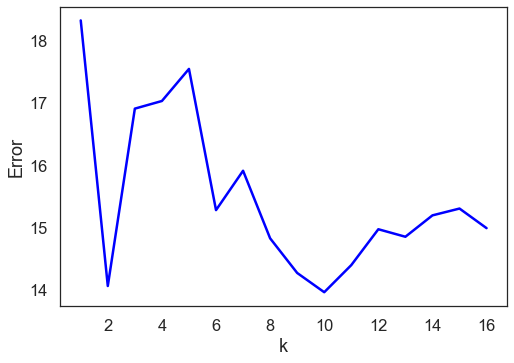

In [34]:
plt.plot(np.arange(len(error_list))+1, error_list, 'b-')
plt.xlabel("k")
plt.ylabel("Error")